In [24]:
!pip install aeon

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 34.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 14.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [58]:
import sqlite3
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ana_utils import convert_listlike_cols, db_path, font_size, font_size_large, df_to_latex_table
import json
from math import inf
import aeon

In [59]:
METRIC = "r2_score"

In [125]:
def sec2str(seconds):
    if seconds < 60:
        return str(seconds) + "s"
    elif seconds < 60*60:
        return str(seconds // 60) + "min"
    else:
        return str(seconds // (60*60)) + "h"

conn = sqlite3.connect(db_path)
#df = pd.read_sql(f"SELECT model, search_space_hash, {METRIC}, data_config_hash, data_id, search_space_name FROM results ", conn)
df = pd.read_sql(f"SELECT results.model, {METRIC}, data_config_hash, data_id, json_extract(search_spaces.config, '$.fit_kwargs') as fit_kwargs FROM results join search_spaces on results.search_space_hash == search_spaces.hash_key", conn)
conn.close()
df = convert_listlike_cols(df)
#list(df[df["model"]=="AutoGluon"]["config"])[0]
df["Model"] = df[["model", "fit_kwargs"]].apply(lambda x: x["model"] if x["fit_kwargs"] is None else f"{x['model']} ({sec2str(json.loads(x['fit_kwargs'])['time_limit'])})", axis=1)
df = df.drop(["fit_kwargs"], axis=1)
df[METRIC] = df[METRIC].apply(
    lambda x: sum(x) / len(x) if x else None
)
# df = df[(df["model"] != "AutoGluon") | (df["Model"] == "AutoGluon (1h)")]
df[df["model"] == "AutoGluon"]

,model,r2_score,data_config_hash,data_id,Model
205,AutoGluon,0.571341,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (1min)
206,AutoGluon,0.595366,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (5min)
207,AutoGluon,0.594433,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (10min)
208,AutoGluon,0.594364,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (30min)
209,AutoGluon,0.593835,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (1h)
...,...,...,...,...,...
1025,AutoGluon,0.941158,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,20,AutoGluon (4h)
1026,AutoGluon,0.997753,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,12,AutoGluon (4h)
1027,AutoGluon,0.869935,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,15,AutoGluon (4h)
1028,AutoGluon,0.943358,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,18,AutoGluon (4h)


In [126]:
data = {
    "Datasets": [grouping for grouping, _ in df.groupby(by=["data_config_hash", "data_id"])],
    "Algorithms": list(df["Model"].unique())
}

errors = []
for data_hash, data_id in data["Datasets"]:
    dataset_errors = []
    df_ = df[(df["data_config_hash"] == data_hash) & (df["data_id"] == data_id)]
    minimum = df_[METRIC].min()
    for algo in data["Algorithms"]:
        algo_perf = df_[df_["Model"] == algo]
        if len(algo_perf) > 0:
            # print(algo_perf)
            algo_perf = algo_perf[METRIC].iloc[0]
        else: 
            algo_perf = minimum
        dataset_errors.append(algo_perf)
    errors.append(dataset_errors)
data['Performance (Error)'] = errors

In [127]:
# SRC: https://dev.to/milenamonteiro/comparing-machine-learning-algorithms-using-friedman-test-and-critical-difference-diagrams-in-python-10a9

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from aeon.visualisation import plot_critical_difference

# Convert the data into a DataFrame
datasets = data['Datasets']
algorithms = data['Algorithms']
performance_data = data['Performance (Error)']

# Create a list of dictionaries for each dataset
rows = []
for dataset, performance in zip(datasets, performance_data):
    row = {'Dataset': dataset}
    row.update({alg: perf for alg, perf in zip(algorithms, performance)})
    rows.append(row)

# Create the DataFrame
df = pd.DataFrame(rows)

# Calculate the ranking of each algorithm for each dataset
rankings_matrix = df[algorithms].rank(axis=1, method='average', ascending=False)

rankings_matrix

,AdaBoost,Bagging,BayesianRidge,CatBoost,DecisionTree,Dummy,ElasticNet,ExtraTrees,GaussianProcess,AutoGluon (1min),...,LightGBM,Tweedie,GradientBoosting,M5,PolynomialRegression,RandomForest,SupportVectorRegression,XGBoost,AutoGluon (4h),MLP
0,25.0,24.0,16.0,14.0,27.0,31.5,19.0,10.0,11.0,6.0,...,8.0,23.0,15.0,13.0,31.5,7.0,31.5,31.5,5.0,9.0
1,14.0,16.0,19.0,11.0,15.0,29.0,23.0,8.0,18.0,10.0,...,9.0,26.0,7.0,13.0,17.0,12.0,32.5,6.0,1.0,30.0
2,11.0,17.0,23.0,9.0,13.0,30.0,25.0,14.0,15.0,8.0,...,10.0,27.0,6.0,12.0,18.0,32.0,32.0,7.0,1.0,19.0
3,13.0,15.0,20.0,8.0,17.0,31.5,27.0,11.0,14.0,6.0,...,10.0,22.0,9.0,12.0,31.5,31.5,31.5,7.0,2.0,16.0
4,9.0,12.0,19.0,10.0,15.0,27.0,20.0,6.0,24.0,13.0,...,14.0,23.0,11.0,8.0,31.5,31.5,31.5,7.0,1.0,29.0
5,14.0,13.0,19.0,8.0,16.0,27.0,20.0,6.0,22.0,10.0,...,11.0,31.0,12.0,9.0,31.0,31.0,31.0,7.0,2.0,23.0
6,17.0,18.0,19.0,11.0,32.5,29.0,22.0,8.0,7.0,6.0,...,16.0,23.0,15.0,13.0,32.5,10.0,14.0,9.0,2.0,27.0
7,27.0,18.0,8.0,20.0,31.5,24.0,5.0,26.0,23.0,9.0,...,22.0,7.0,28.0,16.0,31.5,31.5,25.0,31.5,15.0,21.0
8,12.0,14.0,18.0,10.0,15.0,27.0,23.0,8.0,17.0,7.0,...,13.0,19.0,9.0,1.0,32.5,11.0,26.0,25.0,2.0,28.0
9,13.0,14.0,20.0,8.0,26.0,29.0,22.0,6.0,16.0,7.0,...,11.0,25.0,10.0,12.0,31.5,9.0,31.5,31.5,1.0,27.0


In [128]:
# Format the results
formatted_results = df[algorithms].copy()
for col in formatted_results.columns:
    formatted_results[col] = formatted_results[col].round(3).astype(str) + " (" + rankings_matrix[col].astype(int).astype(str) + ")"

# Add a row for the sum of ranks and average of ranks
sum_ranks = rankings_matrix.sum().round(3).rename('Sum Ranks')
average_ranks = rankings_matrix.mean().round(3).rename('Average Ranks')

# Add the rows to the formatted DataFrame using concat
formatted_results = pd.concat([formatted_results, sum_ranks.to_frame().T, average_ranks.to_frame().T])

# Add the 'Dataset' column to the formatted DataFrame
formatted_results.insert(0, 'Dataset', df['Dataset'].tolist() + ['Sum Ranks', 'Average Ranks'])

formatted_results

,Dataset,AdaBoost,Bagging,BayesianRidge,CatBoost,DecisionTree,Dummy,ElasticNet,ExtraTrees,GaussianProcess,...,LightGBM,Tweedie,GradientBoosting,M5,PolynomialRegression,RandomForest,SupportVectorRegression,XGBoost,AutoGluon (4h),MLP
0,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.501 (25),0.51 (24),0.519 (16),0.538 (14),0.443 (27),-0.002 (31),0.518 (19),0.552 (10),0.551 (11),...,0.553 (8),0.512 (23),0.535 (15),0.539 (13),-0.002 (31),0.56 (7),-0.002 (31),-0.002 (31),0.593 (5),0.553 (9)
1,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.917 (14),0.877 (16),0.504 (19),0.946 (11),0.878 (15),-0.008 (29),0.504 (23),0.963 (8),0.506 (18),...,0.956 (9),0.491 (26),0.967 (7),0.942 (13),0.723 (17),0.942 (12),-3154587631103.819 (32),0.968 (6),0.976 (1),-25.753 (30)
2,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.994 (11),0.862 (17),0.373 (23),0.996 (9),0.986 (13),-0.006 (30),0.365 (25),0.982 (14),0.94 (15),...,0.995 (10),0.361 (27),0.999 (6),0.992 (12),0.853 (18),-0.107 (32),-0.107 (32),0.999 (7),0.999 (1),0.71 (19)
3,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.907 (13),0.887 (15),0.604 (20),0.937 (8),0.808 (17),-0.011 (31),0.542 (27),0.924 (11),0.899 (14),...,0.931 (10),0.603 (22),0.937 (9),0.913 (12),-0.011 (31),-0.011 (31),-0.011 (31),0.94 (7),0.948 (2),0.855 (16)
4,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.678 (9),0.642 (12),0.282 (19),0.671 (10),0.441 (15),-0.0 (27),0.282 (20),0.7 (6),0.272 (24),...,0.641 (14),0.281 (23),0.664 (11),0.678 (8),-4.037032116601437e+19 (31),-4.037032116601437e+19 (31),-4.037032116601437e+19 (31),0.7 (7),0.749 (1),-1811.555 (29)
5,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.919 (14),0.919 (13),0.734 (19),0.929 (8),0.888 (16),-0.001 (27),0.733 (20),0.93 (6),0.721 (22),...,0.925 (11),-54316776.893 (31),0.923 (12),0.926 (9),-54316776.893 (31),-54316776.893 (31),-54316776.893 (31),0.929 (7),0.933 (2),0.691 (23)
6,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.199 (17),0.174 (18),0.171 (19),0.277 (11),-0.337 (32),-0.009 (29),0.168 (22),0.299 (8),0.326 (7),...,0.222 (16),0.165 (23),0.253 (15),0.266 (13),-0.337 (32),0.282 (10),0.254 (14),0.284 (9),0.345 (2),0.14 (27)
7,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,-0.037 (27),0.086 (18),0.12 (8),0.07 (20),-0.218 (31),-0.006 (24),0.121 (5),-0.031 (26),0.014 (23),...,0.054 (22),0.12 (7),-0.052 (28),0.101 (16),-0.218 (31),-0.218 (31),-0.022 (25),-0.218 (31),0.103 (15),0.055 (21)
8,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.996 (12),0.996 (14),0.843 (18),0.997 (10),0.988 (15),-0.001 (27),0.751 (23),0.998 (8),0.962 (17),...,0.996 (13),0.842 (19),0.998 (9),1.0 (1),-32.374 (32),0.997 (11),-0.001 (26),0.246 (25),1.0 (2),-0.244 (28)
9,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.503 (13),0.494 (14),0.267 (20),0.551 (8),0.251 (26),-0.002 (29),0.265 (22),0.573 (6),0.335 (16),...,0.542 (11),0.258 (25),0.549 (10),0.541 (12),-1.268 (31),0.55 (9),-1.268 (31),-1.268 (31),0.586 (1),0.232 (27)


In [129]:
# Perform the Friedman Test
friedman_stat, p_value = friedmanchisquare(*rankings_matrix.T.values)
print(f"Friedman test statistic: {friedman_stat}, p-value = {p_value}")

# Convert the accuracy matrix into a NumPy array for the critical difference diagram
scores = df[algorithms].values
classifiers = df[algorithms].columns.tolist()

#scores[scores<0] = 0
scores

Friedman test statistic: 692.2292442444837, p-value = 4.734909104604458e-125


array([[ 5.01300718e-01,  5.09690934e-01,  5.19487250e-01, ...,
        -1.67520826e-03,  5.93468437e-01,  5.53144601e-01],
       [ 9.17189804e-01,  8.76536597e-01,  5.04142333e-01, ...,
         9.68345912e-01,  9.76411922e-01, -2.57532738e+01],
       [ 9.93828494e-01,  8.61854964e-01,  3.73143879e-01, ...,
         9.98628053e-01,  9.99446460e-01,  7.10336165e-01],
       ...,
       [ 6.16298126e-01,  5.65398090e-01,  5.59630339e-01, ...,
         5.96506989e-01,  6.38330432e-01,  4.90709646e-01],
       [ 9.24150782e-01,  9.34280781e-01,  9.03540933e-01, ...,
         9.35213148e-01,  9.50981627e-01, -1.03944320e-01],
       [ 6.40282030e-01,  6.22523517e-01,  5.70990797e-01, ...,
         6.98499311e-01,  7.75419499e-01, -9.44627414e+08]])

/software/util/JupyterLab/barnard/share/scipy/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:600: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))


<Figure size 1600x2000 with 0 Axes>

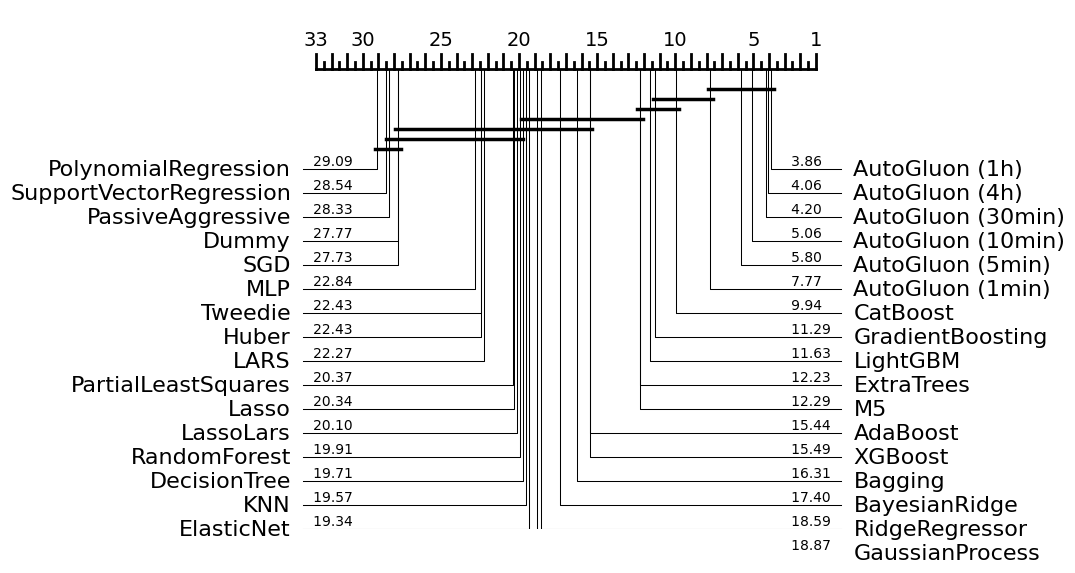

In [205]:
# Set the figure size before plotting
plt.figure(figsize=(16, 20))  # Adjust the figure size as needed

# Generate the critical difference diagram
fig, _ = plot_critical_difference(
    scores, 
    classifiers, 
    lower_better=False,
    test='wilcoxon',  # or nemenyi
    correction='holm', # or bonferroni or none
    alpha=0.01,
    width=6,
    textspace=1
)

# Get the current axes
ax = plt.gca()

# Adjust font size and rotation of x-axis labels
for label in ax.get_xticklabels():
    label.set_fontsize(14) 
    label.set_rotation(45) 
    label.set_horizontalalignment('right')

# Increase padding between labels and axis
ax.tick_params(axis='x', which='major', pad=20)

# Adjust margins to provide more space for labels
plt.subplots_adjust(bottom=0.1)

# Optionally adjust y-axis label font size
ax.tick_params(axis='y', labelsize=font_size)

# Save and display the plot
for txt in ax.texts:
    if txt.get_text().isdigit():   
        # Reduce Overcrowded X-Axis
        if int(txt.get_text()) % 5 != 0 and (int(txt.get_text()) not in (len(classifiers), 1)):
            txt.set_visible(False)
        else:
            txt.set_fontsize(font_size)
    else:
        # Round Rankings
        try: 
            value = float(txt.get_text())
            txt.set_text(f"   {value:.2f}   ")
            #txt.set_fontsize(font_size)
        except:
            pass


plt.savefig('critical_difference_diagram.pdf', format="pdf", bbox_inches="tight", pad_inches=0.5, dpi=900)
plt.show()